# Case/Control Detection Layer

In [27]:
# Enhanced imports with better error handling
%pip install optuna -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import optuna

# Install and import DESlib
!pip install deslib -q
from deslib.dcs import APosteriori
from deslib.des import KNORAE, KNORAU, KNOP, DESMI

from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
import warnings
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Install and import CatBoost
!pip install catboost -q
from catboost import CatBoostClassifier

# Note: LightGBM commented out as requested
# from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
from scipy.stats import friedmanchisquare, rankdata
import shap

!pip install scikit-posthocs -q
import scikit_posthocs as sp

from sklearn.feature_selection import SelectFromModel
from IPython.display import FileLink, display
import math
from sklearn.ensemble import RandomForestClassifier

!pip install scikit-optimize -q
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from deslib.des.knop import KNOP
from deslib.des.meta_des import METADES
from deslib.des.des_knn import DESKNN
from deslib.des.des_p import DESP
from sklearn.model_selection import RandomizedSearchCV

# Set plot style for better visualization
plt.style.use('default')
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


### Preparation before training

In [28]:
# Call Dataset
pd.set_option('display.max_rows', 10)
initial_df = pd.read_csv('consolidated_dataset.csv')
initial_df.info()
initial_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Columns: 128 entries, PtID to ts_number_variability
dtypes: float64(88), int64(1), object(39)
memory usage: 187.1+ KB


,PtID,BCaseControlStatus,DealHypoEp_attitude,UndertreatHypo_attitude,HighBGDamage_attitude,FreqHypoDamage_attitude,DangersHighBG_attitude,HighBGLevTakeAction_attitude,LowBGLevTakeAction_attitude,PtCurrA1cGoal_attitude,...,ts_avg_hypo_total,ts_avg_number_total,ts_avg_hypo_mean,ts_avg_number_mean,ts_avg_hypo_max,ts_avg_number_max,ts_avg_hypo_std,ts_avg_number_std,ts_hypo_variability,ts_number_variability
0,1,Case,Disagree,Disagree,Disagree,Agree,Disagree,170.0,80.0,NaN,...,25.0,120.0,0.402196,1.930539,13.2,18.0,1.749591,2.702625,0.0,0.0
1,2,Control,Neutral,Disagree,Disagree,Neutral,Agree,175.0,80.0,6.8,...,9.0,120.0,0.155735,2.076471,6.0,8.6,0.835011,1.730804,0.0,0.0
2,3,Control,Disagree,Disagree,Disagree,Agree,Disagree,200.0,70.0,NaN,...,1.0,120.0,0.018066,2.167922,1.0,7.8,0.134396,1.785497,0.0,0.0
3,5,Control,Disagree,Disagree,Agree,Agree,Disagree,100.0,70.0,NaN,...,0.0,120.0,0.000000,2.055898,0.0,10.6,0.000000,1.907637,0.0,0.0
4,6,Case,Disagree,Neutral,Disagree,Agree,Disagree,250.0,NaN,7.0,...,10.0,120.0,0.190186,2.282232,5.0,11.6,0.738032,2.030869,0.0,0.0


In [29]:
# All categorical features except for label
cols = initial_df.columns
num_cols = initial_df._get_numeric_data().columns
categorical_features = list(set(cols) - set(num_cols))
if 'BCaseControlStatus' in categorical_features:
    categorical_features.remove('BCaseControlStatus')

# Label Encode all categorical, but keep missing values
le_initial_df = initial_df.copy()
# Remove PtID since it's not a feature but an identifier
if 'PtID' in le_initial_df.columns:
    le_initial_df = le_initial_df.drop('PtID', axis=1)

# Save the target labels and remove from features
dropped_labels = le_initial_df['BCaseControlStatus']
le_initial_df = le_initial_df.drop('BCaseControlStatus', axis=1)

# Label encode categorical features
for col in le_initial_df.columns:
    if le_initial_df[col].dtype == 'object':
        le_initial_df[col] = le_initial_df[col].fillna('missing')

        label_encoder = LabelEncoder()
        le_initial_df[col] = label_encoder.fit_transform(le_initial_df[col])

        # Replace missing values with NaN
        try:
            missing_value_index = np.where(label_encoder.classes_ == 'missing')[0]
            le_initial_df[col] = le_initial_df[col].replace(missing_value_index, np.nan)
        except:
            print(f"No 'missing' values in column {col}")

# Add back the target labels
le_initial_df = pd.concat([le_initial_df, dropped_labels], axis=1)

In [30]:
le_initial_df

,DealHypoEp_attitude,UndertreatHypo_attitude,HighBGDamage_attitude,FreqHypoDamage_attitude,DangersHighBG_attitude,HighBGLevTakeAction_attitude,LowBGLevTakeAction_attitude,PtCurrA1cGoal_attitude,LastFoodIntakeHrs_BMedChart,LastFoodIntakeCarbs_BMedChart,...,ts_avg_number_total,ts_avg_hypo_mean,ts_avg_number_mean,ts_avg_hypo_max,ts_avg_number_max,ts_avg_hypo_std,ts_avg_number_std,ts_hypo_variability,ts_number_variability,BCaseControlStatus
0,1.0,1.0,1.0,0.0,1.0,170.0,80.0,NaN,0.0,15.0,...,120.0,0.402196,1.930539,13.2,18.0,1.749591,2.702625,0.0,0.0,Case
1,2.0,1.0,1.0,2.0,0.0,175.0,80.0,6.8,0.0,22.0,...,120.0,0.155735,2.076471,6.0,8.6,0.835011,1.730804,0.0,0.0,Control
2,1.0,1.0,1.0,0.0,1.0,200.0,70.0,NaN,0.0,40.0,...,120.0,0.018066,2.167922,1.0,7.8,0.134396,1.785497,0.0,0.0,Control
3,1.0,1.0,0.0,0.0,1.0,100.0,70.0,NaN,0.0,30.0,...,120.0,0.000000,2.055898,0.0,10.6,0.000000,1.907637,0.0,0.0,Control
4,1.0,2.0,1.0,0.0,1.0,250.0,NaN,7.0,0.0,61.0,...,120.0,0.190186,2.282232,5.0,11.6,0.738032,2.030869,0.0,0.0,Case
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.0,0.0,0.0,0.0,0.0,200.0,70.0,6.5,0.0,36.0,...,120.0,0.066402,2.656093,1.0,10.0,0.251770,2.448209,0.0,0.0,Case
183,0.0,1.0,0.0,0.0,1.0,150.0,90.0,7.0,0.0,NaN,...,120.0,0.223930,2.239299,6.0,11.6,0.907510,2.005705,0.0,0.0,Case
184,1.0,1.0,1.0,0.0,1.0,250.0,50.0,6.0,0.0,NaN,...,120.0,0.321986,2.575887,10.8,10.8,1.675989,2.513749,0.0,0.0,Case
185,1.0,1.0,1.0,0.0,1.0,200.0,95.0,7.0,0.0,30.0,...,120.0,0.073306,2.199167,2.0,10.4,0.326373,2.226431,0.0,0.0,Case


In [31]:
# Separate data by Case/Control status
le_df_control = le_initial_df[le_initial_df['BCaseControlStatus'] == 'Control']
le_df_case = le_initial_df[le_initial_df['BCaseControlStatus'] == 'Case']

# Check case/control category counts
dataframes = [le_df_control, le_df_case]
le_initial_df = pd.concat(dataframes, ignore_index=True)
label_counts = le_initial_df['BCaseControlStatus'].value_counts()
print("Case/Control counts:")
print(label_counts)

Case/Control counts:
Control    94
Case       93
Name: BCaseControlStatus, dtype: int64


In [32]:
# Remove samples with too many missing values (more than 80%)
threshold = int(0.8 * le_df_control.shape[1])
le_df_control = le_df_control.dropna(thresh=threshold)
threshold = int(0.8 * le_df_case.shape[1])
le_df_case = le_df_case.dropna(thresh=threshold)

# Check case/control category counts after removing outliers
dataframes = [le_df_control, le_df_case]
le_initial_df = pd.concat(dataframes, ignore_index=True)
label_counts = le_initial_df['BCaseControlStatus'].value_counts()
print("Case/Control counts after removing outliers:")
print(label_counts)

Case/Control counts after removing outliers:
Control    94
Case       93
Name: BCaseControlStatus, dtype: int64


In [33]:
# Imputation
different_le_dfs = [le_df_control, le_df_case]
imputed_le_dfs = []
from sklearn.impute import IterativeImputer

for le_df in different_le_dfs:
    y = le_df['BCaseControlStatus']
    X = le_df.drop('BCaseControlStatus', axis=1)
    
    imputer = SimpleImputer(strategy='median')
    imputed_data = imputer.fit_transform(X)
    imputed_df = pd.DataFrame(imputed_data, columns=X.columns)

    imputed_df['BCaseControlStatus'] = y.reset_index(drop=True)
    imputed_le_dfs.append(imputed_df)

concatenated_le_dfs = pd.concat(imputed_le_dfs, ignore_index=True)
print("Dataset shape after imputation:", concatenated_le_dfs.shape)
concatenated_le_dfs.head()

Dataset shape after imputation: (187, 127)


,DealHypoEp_attitude,UndertreatHypo_attitude,HighBGDamage_attitude,FreqHypoDamage_attitude,DangersHighBG_attitude,HighBGLevTakeAction_attitude,LowBGLevTakeAction_attitude,PtCurrA1cGoal_attitude,LastFoodIntakeHrs_BMedChart,LastFoodIntakeCarbs_BMedChart,...,ts_avg_number_total,ts_avg_hypo_mean,ts_avg_number_mean,ts_avg_hypo_max,ts_avg_number_max,ts_avg_hypo_std,ts_avg_number_std,ts_hypo_variability,ts_number_variability,BCaseControlStatus
0,2.0,1.0,1.0,2.0,0.0,175.0,80.0,6.8,0.0,22.0,...,120.0,0.155735,2.076471,6.0,8.6,0.835011,1.730804,0.0,0.0,Control
1,1.0,1.0,1.0,0.0,1.0,200.0,70.0,6.8,0.0,40.0,...,120.0,0.018066,2.167922,1.0,7.8,0.134396,1.785497,0.0,0.0,Control
2,1.0,1.0,0.0,0.0,1.0,100.0,70.0,6.8,0.0,30.0,...,120.0,0.000000,2.055898,0.0,10.6,0.000000,1.907637,0.0,0.0,Control
3,0.0,1.0,2.0,2.0,0.0,170.0,75.0,6.5,1.0,37.5,...,120.0,0.369918,2.096205,10.0,10.0,1.391627,1.714136,0.0,0.0,Control
4,0.0,1.0,1.0,0.0,2.0,200.0,45.0,6.0,0.0,15.0,...,120.0,0.238981,2.031335,7.0,15.6,1.075851,2.209218,0.0,0.0,Control


In [34]:
# Full label encode depression category
fully_LE_concatenated_le_dfs = concatenated_le_dfs.copy()

# Full label encode Case/Control status
fully_LE_concatenated_le_dfs['BCaseControlStatus'] = label_encoder.fit_transform(fully_LE_concatenated_le_dfs['BCaseControlStatus'])

# Print the mapping of encoded values
print("Case/Control Encoding Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} -> {i}")

# The dataset after category connect, imputation, and label encoding
splitted_dataset = fully_LE_concatenated_le_dfs.copy()
splitted_dataset

Case/Control Encoding Mapping:
Case -> 0
Control -> 1


,DealHypoEp_attitude,UndertreatHypo_attitude,HighBGDamage_attitude,FreqHypoDamage_attitude,DangersHighBG_attitude,HighBGLevTakeAction_attitude,LowBGLevTakeAction_attitude,PtCurrA1cGoal_attitude,LastFoodIntakeHrs_BMedChart,LastFoodIntakeCarbs_BMedChart,...,ts_avg_number_total,ts_avg_hypo_mean,ts_avg_number_mean,ts_avg_hypo_max,ts_avg_number_max,ts_avg_hypo_std,ts_avg_number_std,ts_hypo_variability,ts_number_variability,BCaseControlStatus
0,2.0,1.0,1.0,2.0,0.0,175.0,80.0,6.8,0.0,22.0,...,120.0,0.155735,2.076471,6.0,8.6,0.835011,1.730804,0.0,0.0,1
1,1.0,1.0,1.0,0.0,1.0,200.0,70.0,6.8,0.0,40.0,...,120.0,0.018066,2.167922,1.0,7.8,0.134396,1.785497,0.0,0.0,1
2,1.0,1.0,0.0,0.0,1.0,100.0,70.0,6.8,0.0,30.0,...,120.0,0.000000,2.055898,0.0,10.6,0.000000,1.907637,0.0,0.0,1
3,0.0,1.0,2.0,2.0,0.0,170.0,75.0,6.5,1.0,37.5,...,120.0,0.369918,2.096205,10.0,10.0,1.391627,1.714136,0.0,0.0,1
4,0.0,1.0,1.0,0.0,2.0,200.0,45.0,6.0,0.0,15.0,...,120.0,0.238981,2.031335,7.0,15.6,1.075851,2.209218,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.0,0.0,0.0,0.0,0.0,200.0,70.0,6.5,0.0,36.0,...,120.0,0.066402,2.656093,1.0,10.0,0.251770,2.448209,0.0,0.0,0
183,0.0,1.0,0.0,0.0,1.0,150.0,90.0,7.0,0.0,36.0,...,120.0,0.223930,2.239299,6.0,11.6,0.907510,2.005705,0.0,0.0,0
184,1.0,1.0,1.0,0.0,1.0,250.0,50.0,6.0,0.0,36.0,...,120.0,0.321986,2.575887,10.8,10.8,1.675989,2.513749,0.0,0.0,0
185,1.0,1.0,1.0,0.0,1.0,200.0,95.0,7.0,0.0,30.0,...,120.0,0.073306,2.199167,2.0,10.4,0.326373,2.226431,0.0,0.0,0


### Setup for training

In [35]:
def plot_combined_roc_curve(roc_curves, classifier_names):
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))
    
    for i, clf_name in enumerate(classifier_names):
        tprs = []
        for fpr, tpr in roc_curves[clf_name]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2, linestyle='-', marker='o', markersize=4, 
                 label=f'{clf_name} (AUC = {mean_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=26)
    plt.ylabel('True Positive Rate', fontsize=26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="lower right", fontsize=22, frameon=True, framealpha=0.9)
    plt.grid(True)

    filename='bonk.svg'

    plt.savefig(filename, format='svg')
    plt.show()

    display(FileLink(filename))

# Preparation code to make CD diagram from older version of Orange
def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.

    This function is deprecated and will be removed in Orange 3.34.
    """
    k = len(avranks)
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd


def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    This function is deprecated and will be removed in Orange 3.34.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, fontsize = 14, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

def train_evaluate_model(clf, X_train, y_train, X_test, y_test, clf_name='Classifier'):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:
        y_score = clf.decision_function(X_test)
        
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    print(f'{clf_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    return accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc

In [36]:
warnings.filterwarnings('ignore')

### Training (classic/static)
In order to run classical/static, make sure to uncomment the one you need. "Post Training" is after one of these classical/static is done. The model predicts Case vs Control status.

#### Classical Classifiers

In [37]:
# Optimized Classifiers
classifiers = {
    'DT': DecisionTreeClassifier(
        random_state=0, 
        criterion='gini', 
        max_depth=6, 
        min_samples_leaf=10, 
        min_samples_split=9
    ),
    'LR': LogisticRegression(
        random_state=0, 
        C=0.09659168435718246, 
        max_iter=100, 
        solver='lbfgs'
    ),
    'NB': GaussianNB(
        var_smoothing=0.0058873326349240295
    ),
    'KN': KNeighborsClassifier(
        metric='manhattan', 
        n_neighbors=8, 
        weights='uniform'
    ),
    'MLP': MLPClassifier(
        random_state=0, 
        max_iter=1000, 
        alpha=0.0003079393718075164, 
        hidden_layer_sizes=195, 
        learning_rate_init=0.0001675266159417717
    ),
    'SVC': SVC(probability=True, kernel='rbf', C=0.95, gamma='scale')
}

# Main
# Initialize
metric_sums_classic = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices_classic = defaultdict(list)
roc_curves_classic = defaultdict(list)
roc_aucs_classic  = defaultdict(list)
accuracy_scores_classic  = defaultdict(list)
precision_scores_classic  = defaultdict(list)
recall_scores_classic  = defaultdict(list)
f1_scores_classic  = defaultdict(list)

# Loop over 10 different random states
for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    # Splitting the data
    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    # Identify outliers in the training dataset
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    # Select all rows that are not outliers
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    # SMOTE
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {y_res.value_counts()}")

    print(f"Number of test labels before resampling: {y_test.value_counts()}")
    
    # Get count of minority class
    min_count = y_test.value_counts().min()
    # Set up strategy to balance classes
    sampling_strategy_undersample = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)
    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    # Normalization
    scaler = MinMaxScaler()
    
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    # Correlation Feat Analysis
    corr_df = X_res.copy()
    corr_df['target'] = y_res
    
    corr_mat = corr_df.corr()
    target_correlation = corr_mat['target'].drop('target')
    top_features = target_correlation.abs().sort_values(ascending=False).head(100).index.tolist()
    
    # Only take top features
    X_res_fi = X_res[top_features]
    X_test_fi = X_test[top_features]

    # Evaluate classifiers
    for clf_name, clf in classifiers.items():
        # Ensure the random state for classifiers is consistent
        if hasattr(clf, 'random_state'):
            clf.set_params(random_state=random_state)
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        metric_sums_classic[clf_name]['accuracy'] += accuracy
        metric_sums_classic[clf_name]['precision'] += precision
        metric_sums_classic[clf_name]['recall'] += recall
        metric_sums_classic[clf_name]['f1'] += f1
        conf_matrices_classic[clf_name].append(conf_matrix)
        roc_curves_classic[clf_name].append((fpr, tpr))
        roc_aucs_classic[clf_name].append(roc_auc)
        accuracy_scores_classic[clf_name].append(accuracy)
        precision_scores_classic[clf_name].append(precision)
        recall_scores_classic[clf_name].append(recall)
        f1_scores_classic[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    28
1    28
Name: BCaseControlStatus, dtype: int64
DT - Accuracy: 0.8036, Precision: 0.8071, Recall: 0.8036, F1-Score: 0.8030
LR - Accuracy: 0.7857, Precision: 0.7995, Recall: 0.7857, F1-Score: 0.7832
NB - Accuracy: 0.6607, Precision: 0.6900, Recall: 0.6607, F1-Score: 0.6471
KN - Accuracy: 0.8036, Precision: 0.8040, Recall: 0.8036, F1-Score: 0.8035
MLP - Accuracy: 0.7321, Precision: 0.7476, Recall: 0.7321, F1-Score: 0.7279
SVC - Accuracy: 0.7679, Precision: 0.7767, Recall: 0.7679, F1-Score: 0.7660
Processing for Random State: 1
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of t


Average Metrics over 10 Random States:
DT - Accuracy: 0.7500 ± 0.0459, Precision: 0.7530 ± 0.0466, Recall: 0.7500 ± 0.0459, F1-Score: 0.7493 ± 0.0460, AUC: 0.8131
LR - Accuracy: 0.7089 ± 0.0392, Precision: 0.7128 ± 0.0421, Recall: 0.7089 ± 0.0392, F1-Score: 0.7078 ± 0.0388, AUC: 0.8256
NB - Accuracy: 0.7054 ± 0.0650, Precision: 0.7189 ± 0.0609, Recall: 0.7054 ± 0.0650, F1-Score: 0.6984 ± 0.0719, AUC: 0.7922
KN - Accuracy: 0.7018 ± 0.0505, Precision: 0.7065 ± 0.0503, Recall: 0.7018 ± 0.0505, F1-Score: 0.6999 ± 0.0511, AUC: 0.7906
MLP - Accuracy: 0.7018 ± 0.0366, Precision: 0.7093 ± 0.0390, Recall: 0.7018 ± 0.0366, F1-Score: 0.6992 ± 0.0367, AUC: 0.7862
SVC - Accuracy: 0.7250 ± 0.0350, Precision: 0.7304 ± 0.0377, Recall: 0.7250 ± 0.0350, F1-Score: 0.7235 ± 0.0348, AUC: 0.8415


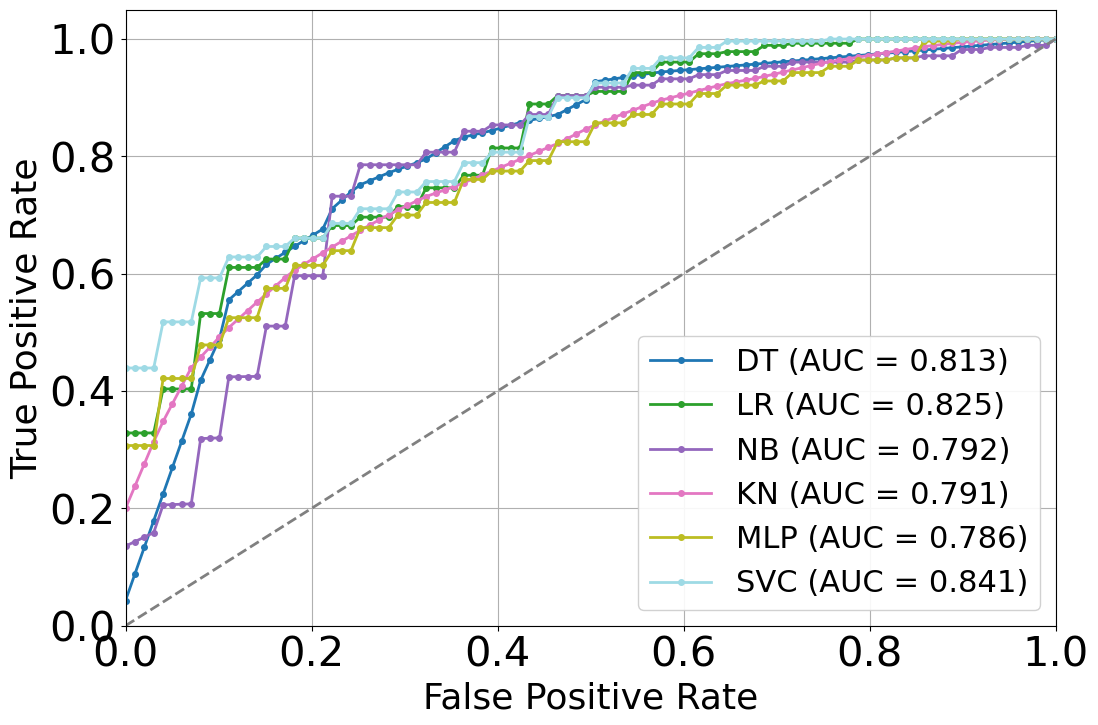

/home/researchsrv1/clement/DES4DepressionTest/code/bonk.svg

Friedman Test Statistic: 11.288819875776381, p-value: 0.04594489123593973
Critical Difference: 2.384234260914288


<Figure size 1400x800 with 0 Axes>

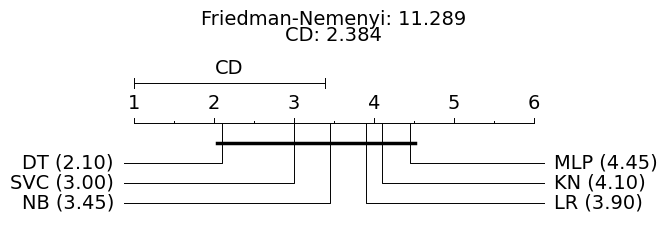

In [38]:
print('\nAverage Metrics over 10 Random States:')
for clf_name, metrics in metric_sums_classic.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores_classic[clf_name])
    std_precision = np.std(precision_scores_classic[clf_name])
    std_recall = np.std(recall_scores_classic[clf_name])
    std_f1 = np.std(f1_scores_classic[clf_name])
    avg_auc = np.mean(roc_aucs_classic[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')

# Plot ROC Curves for each classifier in one graph
plot_combined_roc_curve(roc_curves_classic, classifiers.keys())

# Friedman Test and CD Diagram
df = pd.DataFrame(accuracy_scores_classic)
scores = [df[col].values for col in df.columns]
stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')
ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values
n_datasets = df.shape[0]
alpha = 0.05
cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')
classifiers_ranked = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks, classifiers_ranked, cd=cd, width=6, textspace=1)
plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.10, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.tight_layout()

#### Static Classifiers

In [39]:
# Initialize
metric_sums_static = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices_static = defaultdict(list)
roc_curves_static = defaultdict(list)
roc_aucs_static = defaultdict(list)
accuracy_scores_static = defaultdict(list)
precision_scores_static = defaultdict(list)
recall_scores_static = defaultdict(list)
f1_scores_static = defaultdict(list)

# Base classifiers for ensemble methods
base_rf = RandomForestClassifier(random_state=0)
base_ab = AdaBoostClassifier(random_state=0)
base_cb = CatBoostClassifier(random_state=0, verbose=0)

# Optimized Classifiers
classifiers = {
    'RF': RandomForestClassifier(random_state=0),
    'XGB': XGBClassifier(random_state=0, eval_metric='logloss'),
    'GB': GradientBoostingClassifier(random_state=0),
    'AB': AdaBoostClassifier(random_state=0),
    'CB': CatBoostClassifier(random_state=0, verbose=0),
    'VOT': VotingClassifier(
        estimators=[('rf', base_rf), ('ab', base_ab), ('cb', base_cb)],
        voting='soft'
    ),
    'STACK': StackingClassifier(
        estimators=[('rf', base_rf), ('ab', base_ab), ('cb', base_cb)],
        final_estimator=LogisticRegression(random_state=0),
        cv=5
    )
}

# Define the number of features for each classifier
num_features = {
     'RF': 100,
     'XGB': 100,
     'GB': 100,
     'AB': 100,
     'CB': 100,
     'VOT': 100,
     'STACK': 100,
     # 'LGBM': 150,
}

for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {y_res.value_counts()}")

    print(f"Number of test labels before resampling: {y_test.value_counts()}") 
    
    # Get count of minority class
    min_count = y_test.value_counts().min()
    # Set up strategy to balance classes
    sampling_strategy_undersample = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()
    
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg.fit(X_res, y_res)
    selector = SelectFromModel(log_reg, prefit=True)
    
    importance = np.abs(log_reg.coef_[0])
    indices = np.argsort(importance)[::-1]
    important_features = [original_columns[i] for i in indices]

    for clf_name, clf in classifiers.items():
        # Set random state for ensemble classifiers
        if clf_name in ['VOT', 'STACK']:
            for name, estimator in clf.estimators:
                if hasattr(estimator, 'random_state'):
                    estimator.set_params(random_state=random_state)
            if clf_name == 'STACK' and hasattr(clf.final_estimator, 'random_state'):
                clf.final_estimator.set_params(random_state=random_state)
        elif hasattr(clf, 'random_state'):
            clf.set_params(random_state=random_state)
            
        num_top_features = num_features[clf_name]
        selected_features = important_features[:num_top_features]
        
        X_res_fi = pd.DataFrame(X_res, columns=original_columns)[selected_features]
        X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]

        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
            clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name
        )
        metric_sums_static[clf_name]['accuracy'] += accuracy
        metric_sums_static[clf_name]['precision'] += precision
        metric_sums_static[clf_name]['recall'] += recall
        metric_sums_static[clf_name]['f1'] += f1
        conf_matrices_static[clf_name].append(conf_matrix)
        roc_curves_static[clf_name].append((fpr, tpr))
        roc_aucs_static[clf_name].append(roc_auc)
        accuracy_scores_static[clf_name].append(accuracy)
        precision_scores_static[clf_name].append(precision)
        recall_scores_static[clf_name].append(recall)
        f1_scores_static[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    28
1    28
Name: BCaseControlStatus, dtype: int64
RF - Accuracy: 0.8214, Precision: 0.8369, Recall: 0.8214, F1-Score: 0.8194
XGB - Accuracy: 0.8393, Precision: 0.8505, Recall: 0.8393, F1-Score: 0.8380
GB - Accuracy: 0.8214, Precision: 0.8281, Recall: 0.8214, F1-Score: 0.8205
AB - Accuracy: 0.7679, Precision: 0.7767, Recall: 0.7679, F1-Score: 0.7660
CB - Accuracy: 0.8750, Precision: 0.8755, Recall: 0.8750, F1-Score: 0.8750
VOT - Accuracy: 0.8393, Precision: 0.8432, Recall: 0.8393, F1-Score: 0.8388
STACK - Accuracy: 0.8571, Precision: 0.8646, Recall: 0.8571, F1-Score: 0.8564
Processing for Random State: 1
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before 

### Post Training (classic/static)
Only run after one of the training methods above are done

In [40]:
print('\nAverage Metrics over 10 Random States:')
for clf_name, metrics in metric_sums_static.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores_static[clf_name])
    std_precision = np.std(precision_scores_static[clf_name])
    std_recall = np.std(recall_scores_static[clf_name])
    std_f1 = np.std(f1_scores_static[clf_name])
    avg_auc = np.mean(roc_aucs_static[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')


Average Metrics over 10 Random States:
RF - Accuracy: 0.7732 ± 0.0430, Precision: 0.7782 ± 0.0435, Recall: 0.7732 ± 0.0430, F1-Score: 0.7721 ± 0.0437, AUC: 0.8776
XGB - Accuracy: 0.7804 ± 0.0505, Precision: 0.7845 ± 0.0501, Recall: 0.7804 ± 0.0505, F1-Score: 0.7794 ± 0.0512, AUC: 0.8810
GB - Accuracy: 0.7750 ± 0.0609, Precision: 0.7818 ± 0.0586, Recall: 0.7750 ± 0.0609, F1-Score: 0.7732 ± 0.0624, AUC: 0.8643
AB - Accuracy: 0.7589 ± 0.0655, Precision: 0.7656 ± 0.0636, Recall: 0.7589 ± 0.0655, F1-Score: 0.7569 ± 0.0670, AUC: 0.8301
CB - Accuracy: 0.8125 ± 0.0481, Precision: 0.8186 ± 0.0452, Recall: 0.8125 ± 0.0481, F1-Score: 0.8114 ± 0.0489, AUC: 0.8967
VOT - Accuracy: 0.8000 ± 0.0390, Precision: 0.8045 ± 0.0397, Recall: 0.8000 ± 0.0390, F1-Score: 0.7993 ± 0.0391, AUC: 0.8971
STACK - Accuracy: 0.8089 ± 0.0330, Precision: 0.8131 ± 0.0336, Recall: 0.8089 ± 0.0330, F1-Score: 0.8083 ± 0.0331, AUC: 0.8992


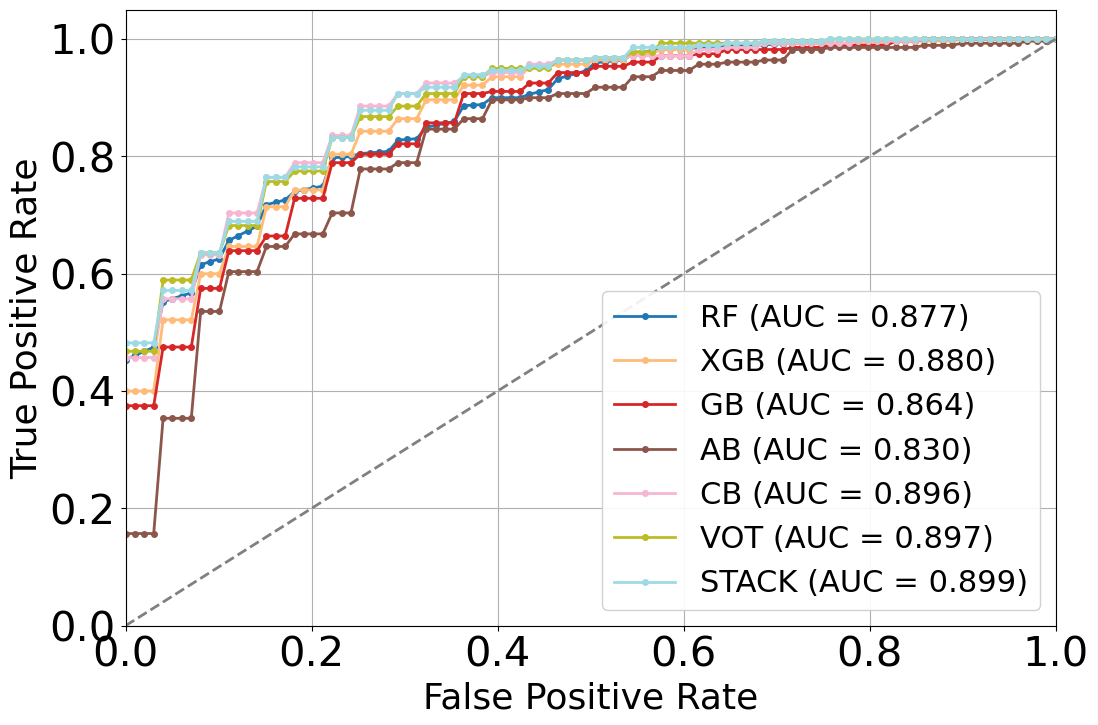

/home/researchsrv1/clement/DES4DepressionTest/code/bonk.svg

In [41]:
# Plot ROC Curves for each classifier in one graph
plot_combined_roc_curve(roc_curves_static, classifiers.keys())

Friedman Test Statistic: 23.757692307692334, p-value: 0.0005786515006431585
Critical Difference: 2.8483477258883494


<Figure size 1400x800 with 0 Axes>

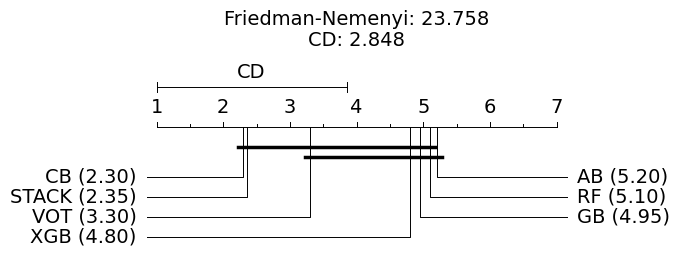

In [42]:
# FN Curve
df = pd.DataFrame(accuracy_scores_static)
scores = [df[col].values for col in df.columns]
stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')
ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values
n_datasets = df.shape[0]
alpha = 0.05
cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')
classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.08, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.tight_layout()

### Hyperparameter optimization (classic/static)

In [ ]:
# Hyperparameter optimization static - Clear previous results first
metric_sums_static = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices_static = defaultdict(list)
roc_curves_static = defaultdict(list)
roc_aucs_static = defaultdict(list)
accuracy_scores_static = defaultdict(list)
precision_scores_static = defaultdict(list)
recall_scores_static = defaultdict(list)
f1_scores_static = defaultdict(list)

if not hasattr(np, 'float'):
    np.float = float
    
if not hasattr(np, 'int'):
    np.int = int

def get_fresh_classifier(clf_name):
    """Return a fresh instance of the classifier"""
    classifiers_fresh = {
        'RandomForest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
        'VotingClassifier': VotingClassifier([
            ('rf', RandomForestClassifier()),
            ('ada', AdaBoostClassifier()),
            ('cat', CatBoostClassifier(verbose=0))
        ], voting='soft'),
        'StackingClassifier': StackingClassifier([
            ('rf', RandomForestClassifier()),
            ('ada', AdaBoostClassifier()),
            ('cat', CatBoostClassifier(verbose=0))
        ], final_estimator=LogisticRegression(), cv=3)
        # Uncomment if needed
        # 'LightGBM': LGBMClassifier()
    }
    return classifiers_fresh[clf_name]

classifiers = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'VotingClassifier': VotingClassifier([
        ('rf', RandomForestClassifier()),
        ('ada', AdaBoostClassifier()),
        ('cat', CatBoostClassifier(verbose=0))
    ], voting='soft'),
    'StackingClassifier': StackingClassifier([
        ('rf', RandomForestClassifier()),
        ('ada', AdaBoostClassifier()),
        ('cat', CatBoostClassifier(verbose=0))
    ], final_estimator=LogisticRegression(), cv=3)
    # Uncomment if needed
    # 'LightGBM': LGBMClassifier()
}

num_features = {
     'RandomForest': 100,
     'XGBoost': 100,
     'GradientBoosting': 100,
     'AdaBoost': 100,
     'CatBoost': 100,
     'VotingClassifier': 100,
     'StackingClassifier': 100,
     # 'LightGBM': 100,
}

search_spaces = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 7, 15],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'gamma': [0, 0.2, 0.4],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [5, 10],
        'subsample': [0.7, 0.9, 1.0],
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
    },
    'VotingClassifier': {
        'rf__n_estimators': [100, 200],
        'ada__n_estimators': [100, 200],
        'cat__iterations': [100, 200]
    },
    'StackingClassifier': {
        'rf__n_estimators': [100, 200],
        'ada__n_estimators': [100, 200],
        'cat__iterations': [100, 200],
        'final_estimator__C': [0.1, 1.0, 10.0]
    },
    # 'LightGBM': {
    #     'n_estimators': [100, 200, 300],
    #     'num_leaves': [31, 63, 127],
    #     'learning_rate': [0.01, 0.1, 0.2],
    #     'subsample': [0.7, 0.9, 1.0],
    # }
}

def convert_params_to_int(params):
    """Convert float parameters to int where needed"""
    int_params = ['n_estimators', 'max_depth', 'iterations', 'depth', 'num_leaves',
                  'rf__n_estimators', 'ada__n_estimators', 'cat__iterations']
    
    for param in int_params:
        if param in params and params[param] is not None:
            params[param] = int(params[param])
    return params

def hyperparameter_optimization(clf, search_space, X, y):
    combined_results = []
    for random_state in range(3):
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        opt = BayesSearchCV(clf, search_space, n_iter=30, cv=cv, random_state=random_state, n_jobs=-1, verbose=0)
        opt.fit(X, y)
        combined_results.append(opt.best_params_)
    best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
    return best_params

# Fixed: Run for all 10 random states instead of just range(9,10)
for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {y_res.value_counts()}")

    print(f"Number of test labels before resampling: {y_test.value_counts()}") 
    
    # Get count of minority class
    min_count = y_test.value_counts().min()
    # Set up strategy to balance classes
    sampling_strategy_undersample = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()
    
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg.fit(X_res, y_res)
    selector = SelectFromModel(log_reg, prefit=True)
    
    importance = np.abs(log_reg.coef_[0])
    indices = np.argsort(importance)[::-1]
    important_features = [original_columns[i] for i in indices[:300]]

    for clf_name, clf in classifiers.items():
        print(f"Optimizing {clf_name}")
        num_top_features = num_features[clf_name]
        selected_features = important_features[:num_top_features]
        
        X_res_fi = pd.DataFrame(X_res, columns=original_columns)[selected_features]
        
        best_params = hyperparameter_optimization(clf, search_spaces[clf_name], X_res_fi, y_res)
        
        # Convert float parameters to int
        best_params = convert_params_to_int(best_params)
        
        # Create a fresh classifier instance and set optimized parameters
        clf_optimized = get_fresh_classifier(clf_name)
        clf_optimized.set_params(**best_params)
        print(f"Best parameters for {clf_name}: {best_params}")

        X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf_optimized, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        metric_sums_static[clf_name]['accuracy'] += accuracy
        metric_sums_static[clf_name]['precision'] += precision
        metric_sums_static[clf_name]['recall'] += recall
        metric_sums_static[clf_name]['f1'] += f1
        conf_matrices_static[clf_name].append(conf_matrix)
        roc_curves_static[clf_name].append((fpr, tpr))
        roc_aucs_static[clf_name].append(roc_auc)
        accuracy_scores_static[clf_name].append(accuracy)
        precision_scores_static[clf_name].append(precision)
        recall_scores_static[clf_name].append(recall)
        f1_scores_static[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    28
1    28
Name: BCaseControlStatus, dtype: int64
Optimizing RandomForest
Best parameters for RandomForest: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 200}
RandomForest - Accuracy: 0.8393, Precision: 0.8505, Recall: 0.8393, F1-Score: 0.8380
Optimizing XGBoost
Best parameters for XGBoost: {'gamma': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
XGBoost - Accuracy: 0.8214, Precision: 0.8231, Recall: 0.8214, F1-Score: 0.8212
Optimizing AdaBoost
Best parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost - Accuracy: 0.8214, Precision: 0.8214, Recall: 0.8214, F1-Score: 0.8214
Optimizing GradientBoosting
Best parameters for GradientBoos

In [52]:
print('\nAverage Metrics over 10 Random States:')
for clf_name, metrics in metric_sums_static.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores_static[clf_name])
    std_precision = np.std(precision_scores_static[clf_name])
    std_recall = np.std(recall_scores_static[clf_name])
    std_f1 = np.std(f1_scores_static[clf_name])
    avg_auc = np.mean(roc_aucs_static[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')


Average Metrics over 10 Random States:
RandomForest - Accuracy: 0.7821 ± 0.0569, Precision: 0.7886 ± 0.0564, Recall: 0.7821 ± 0.0569, F1-Score: 0.7807 ± 0.0578, AUC: 0.8876
XGBoost - Accuracy: 0.7696 ± 0.0489, Precision: 0.7736 ± 0.0480, Recall: 0.7696 ± 0.0489, F1-Score: 0.7686 ± 0.0497, AUC: 0.8688
AdaBoost - Accuracy: 0.7786 ± 0.0350, Precision: 0.7875 ± 0.0303, Recall: 0.7786 ± 0.0350, F1-Score: 0.7765 ± 0.0366, AUC: 0.8751
GradientBoosting - Accuracy: 0.7786 ± 0.0480, Precision: 0.7855 ± 0.0460, Recall: 0.7786 ± 0.0480, F1-Score: 0.7770 ± 0.0488, AUC: 0.8554
CatBoost - Accuracy: 0.8089 ± 0.0524, Precision: 0.8154 ± 0.0492, Recall: 0.8089 ± 0.0524, F1-Score: 0.8077 ± 0.0533, AUC: 0.8876
VotingClassifier - Accuracy: 0.7946 ± 0.0385, Precision: 0.7997 ± 0.0387, Recall: 0.7946 ± 0.0385, F1-Score: 0.7937 ± 0.0388, AUC: 0.8943
StackingClassifier - Accuracy: 0.7982 ± 0.0438, Precision: 0.8017 ± 0.0428, Recall: 0.7982 ± 0.0438, F1-Score: 0.7975 ± 0.0442, AUC: 0.9003


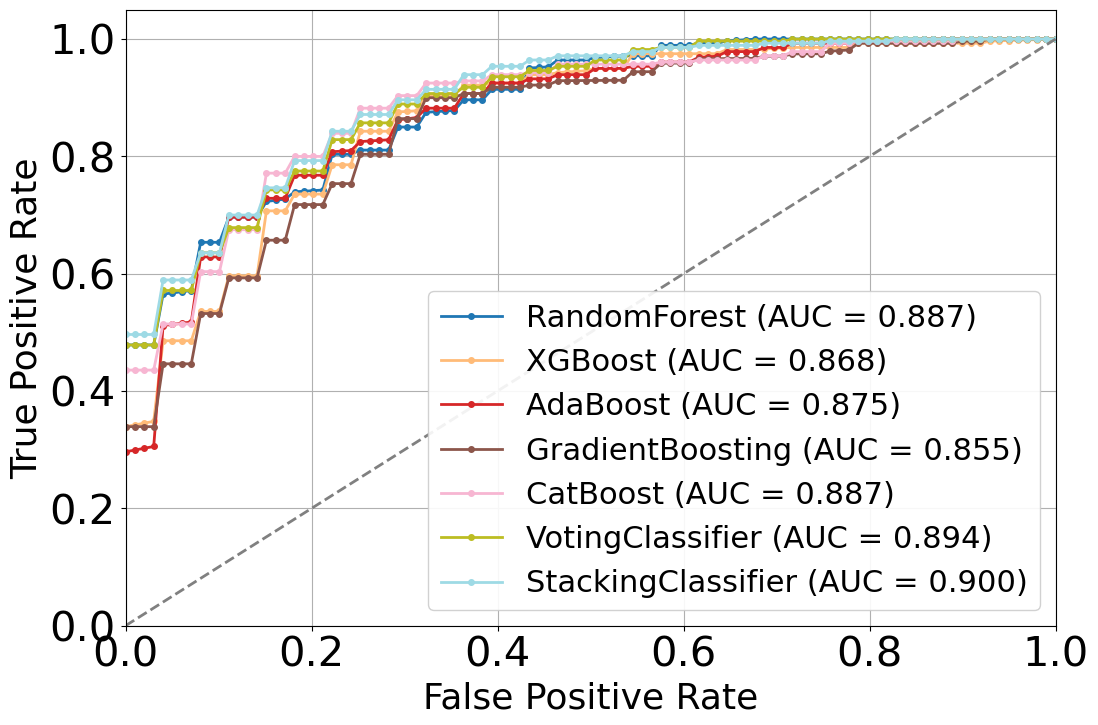

/home/researchsrv1/clement/DES4DepressionTest/code/bonk.svg

In [53]:
plot_combined_roc_curve(roc_curves_static, classifiers.keys())

Friedman Test Statistic: 16.44022770398481, p-value: 0.011576343030402683
Critical Difference: 2.8483477258883494


<Figure size 1400x800 with 0 Axes>

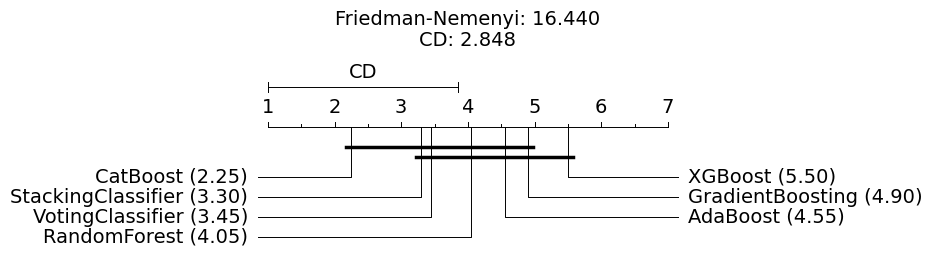

In [54]:
# FN Curve
df = pd.DataFrame(accuracy_scores_static)
scores = [df[col].values for col in df.columns]
stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')
ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values
n_datasets = df.shape[0]
alpha = 0.05
cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')
classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.08, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.tight_layout()

### DES Training for Case/Control Classification

In [66]:
from sklearn.base import clone
from copy import deepcopy
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
import numpy as np

if not hasattr(np, 'float'):
    np.float = float
    
if not hasattr(np, 'int'):
    np.int = int

metric_sums_des = {
    'KNORAE': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNORAU': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESMI': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-U': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-E': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
}

conf_matrices_des = {
    'KNORAE': [],
    'KNORAU': [],
    'KNOP': [],
    'DESMI': [],
    'METADES': [],
    'DESKNN': [],
    'DESP': [],
    'FIRE-KNORA-U': [],
    'FIRE-KNORA-E': [],
    'FIRE-METADES': [],
    'FIRE-DESKNN': [],
    'FIRE-DESP': [],
    'FIRE-KNOP': [],
}

roc_curves = defaultdict(list)
roc_aucs = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)
feature_importance_runs = []

# Fonction pour créer des classificateurs de base frais (incluant Voting et Stacking)
def create_base_classifiers(random_state):
    """Crée des instances fraîches de classificateurs de base pour chaque itération"""
    base_classifiers = [
        RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=7, random_state=random_state, bootstrap=False),
        CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, random_state=random_state, verbose=0),
        AdaBoostClassifier(n_estimators=200, learning_rate=0.1, algorithm='SAMME', random_state=random_state),
        XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
        GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=random_state)
    ]
    
    # Ajouter Voting et Stacking comme classificateurs de base
    voting_clf = VotingClassifier([
        ('rf', RandomForestClassifier(random_state=random_state)),
        ('ada', AdaBoostClassifier(random_state=random_state)),
        ('cat', CatBoostClassifier(verbose=0, random_state=random_state))
    ], voting='soft')
    
    stacking_clf = StackingClassifier([
        ('rf', RandomForestClassifier(random_state=random_state)),
        ('ada', AdaBoostClassifier(random_state=random_state)),
        ('cat', CatBoostClassifier(verbose=0, random_state=random_state))
    ], final_estimator=LogisticRegression(random_state=random_state), cv=3)
    
    base_classifiers.extend([voting_clf, stacking_clf])
    
    return base_classifiers

# Espaces de recherche pour l'optimisation bayésienne
def get_search_space(des_name):
    """Définit l'espace de recherche pour chaque algorithme DES"""
    if des_name == 'KNORAE':
        return [
            Integer(3, 15, name='k'),
            Categorical([True, False], name='with_IH')
        ]
    elif des_name == 'KNORAU':
        return [
            Integer(3, 15, name='k'),
            Categorical([True, False], name='with_IH')
        ]
    elif des_name == 'METADES' or des_name == 'FIRE-METADES':
        return [
            Integer(3, 15, name='k'),
            Real(0.5, 0.9, name='Hc')  # Hc doit être > 0.5
        ]
    elif des_name in ['DESKNN', 'FIRE-DESKNN']:
        return [
            Integer(3, 15, name='k'),
            Real(0.1, 0.9, name='theta')
        ]
    elif des_name in ['DESP', 'FIRE-DESP']:
        return [
            Integer(3, 15, name='k'),
            Real(0.1, 0.9, name='theta')
        ]
    elif des_name in ['KNOP', 'FIRE-KNOP']:
        return [
            Integer(3, 15, name='k')
        ]
    elif des_name == 'DESMI':
        return [
            Integer(3, 15, name='k'),
            Real(0.1, 0.9, name='theta')
        ]
    elif des_name == 'FIRE-KNORA-U':
        return [
            Integer(3, 15, name='k')
        ]
    elif des_name == 'FIRE-KNORA-E':
        return [
            Integer(3, 15, name='k'),
            Categorical([True, False], name='with_IH')
        ]
    else:
        return [Integer(3, 15, name='k')]

def create_des_model(des_name, model_pool, random_state, **params):
    """Crée un modèle DES avec les paramètres spécifiés"""
    # Convertir k en entier si nécessaire
    if 'k' in params:
        params['k'] = int(params['k'])
    
    if des_name == 'KNORAE':
        return KNORAE(
            pool_classifiers=model_pool,
            DFP=False,
            random_state=random_state,
            k=params.get('k', 7),
            with_IH=params.get('with_IH', True)
        )
    elif des_name == 'KNORAU':
        return KNORAU(
            pool_classifiers=model_pool,
            DFP=False,
            random_state=random_state,
            k=params.get('k', 7),
            with_IH=params.get('with_IH', True)
        )
    elif des_name == 'METADES':
        return METADES(
            pool_classifiers=model_pool,
            DFP=False,
            random_state=random_state,
            k=params.get('k', 7),
            Hc=params.get('Hc', 0.5)
        )
    elif des_name == 'FIRE-KNORA-U':
        return KNORAU(
            pool_classifiers=model_pool,
            DFP=True,
            random_state=random_state,
            k=params.get('k', 7)
        )
    elif des_name == 'FIRE-KNORA-E':
        return KNORAE(
            pool_classifiers=model_pool,
            DFP=True,
            random_state=random_state,
            k=params.get('k', 7),
            with_IH=params.get('with_IH', True)
        )
    elif des_name == 'FIRE-METADES':
        return METADES(
            pool_classifiers=model_pool,
            DFP=True,
            random_state=random_state,
            k=params.get('k', 7),
            Hc=params.get('Hc', 0.5)
        )
    elif des_name == 'DESKNN':
        return DESKNN(
            pool_classifiers=model_pool,
            DFP=False,
            random_state=random_state,
            k=params.get('k', 7),
            theta=params.get('theta', 0.5)
        )
    elif des_name == 'FIRE-DESKNN':
        return DESKNN(
            pool_classifiers=model_pool,
            DFP=True,
            random_state=random_state,
            k=params.get('k', 7),
            theta=params.get('theta', 0.5)
        )
    elif des_name == 'DESP':
        return DESP(
            pool_classifiers=model_pool,
            DFP=False,
            random_state=random_state,
            k=params.get('k', 7),
            theta=params.get('theta', 0.5)
        )
    elif des_name == 'FIRE-DESP':
        return DESP(
            pool_classifiers=model_pool,
            DFP=True,
            random_state=random_state,
            k=params.get('k', 7),
            theta=params.get('theta', 0.5)
        )
    elif des_name == 'KNOP':
        return KNOP(
            pool_classifiers=model_pool,
            DFP=False,
            random_state=random_state,
            k=params.get('k', 7)
        )
    elif des_name == 'FIRE-KNOP':
        return KNOP(
            pool_classifiers=model_pool,
            DFP=True,
            random_state=random_state,
            k=params.get('k', 7)
        )
    elif des_name == 'DESMI':
        return DESMI(
            pool_classifiers=model_pool,
            DFP=False,
            random_state=random_state,
            k=params.get('k', 7),
            theta=params.get('theta', 0.5)
        )

def optimize_des_model(des_name, model_pool, X_train_val, y_train_val, X_val, y_val, random_state, n_calls=20):
    """Optimise les hyperparamètres d'un modèle DES avec l'optimisation bayésienne"""
    search_space = get_search_space(des_name)
    
    @use_named_args(search_space)
    def objective(**params):
        try:
            # Créer le modèle DES avec les paramètres actuels
            des_model = create_des_model(des_name, model_pool, random_state, **params)
            
            # Entraîner et évaluer le modèle
            des_model.fit(X_train_val, y_train_val)
            y_pred = des_model.predict(X_val)
            
            # Calculer l'accuracy (on veut minimiser 1 - accuracy)
            accuracy = accuracy_score(y_val, y_pred)
            return 1 - accuracy
            
        except Exception as e:
            print(f"Error during optimization for {des_name}: {e}")
            return 1.0  # Retourner une valeur élevée en cas d'erreur
    
    # Optimisation bayésienne
    result = gp_minimize(objective, search_space, n_calls=n_calls, random_state=random_state)
    
    # Extraire les meilleurs paramètres
    best_params = {}
    for i, param_name in enumerate([space.name for space in search_space]):
        best_params[param_name] = result.x[i]
    
    return best_params, 1 - result.fun  # Retourner la meilleure accuracy

for random_state in range(15, 25):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of test labels before resampling: {y_test.value_counts()}")
    
    min_count = y_test.value_counts().min()
    sampling_strategy_undersample = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test) 

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    xgb_fs = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    xgb_fs.fit(X_res, y_res)

    feature_importances = xgb_fs.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    top_50_features = [original_columns[i] for i in indices[:50]]
    current_run_features = {original_columns[i]: feature_importances[i] for i in indices[:50]}
    
    feature_importance_runs.append(current_run_features)

    X_res_fi = X_res[top_50_features]
    X_test_fi = X_test[top_50_features]
    
    # Split training data for validation
    X_train_val, X_val, y_train_val, y_val = train_test_split(
        X_res_fi, y_res, test_size=0.2, stratify=y_res, random_state=random_state
    )
    
    # Créer le pool de modèles de base (incluant Voting et Stacking)
    base_clfs = create_base_classifiers(random_state)
    model_pool = []
    for clf in base_clfs:
        print(f"Training base classifier: {type(clf).__name__}")
        clf_copy = clone(clf)
        clf_copy.fit(X_res_fi, y_res)
        model_pool.append(clf_copy)
    
    # Optimisation bayésienne pour chaque algorithme DES
    for des_name in ['KNORAE', 'KNORAU', 'METADES', 'FIRE-KNORA-U', 'FIRE-KNORA-E']:
        try:
            print(f"Optimizing {des_name} with Bayesian optimization...")
            
            # Optimisation des hyperparamètres
            best_params, best_score = optimize_des_model(
                des_name, model_pool, X_train_val, y_train_val, X_val, y_val, random_state, n_calls=15
            )
            
            print(f"Best parameters for {des_name}: {best_params}")
            print(f"Best validation accuracy: {best_score:.4f}")
            
            # Créer et entraîner le modèle final avec les meilleurs paramètres
            des_model = create_des_model(des_name, model_pool, random_state, **best_params)
            
            # Évaluer le modèle final
            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                des_model, X_res_fi, y_res, X_test_fi, y_test, clf_name=des_name
            )
            
            metric_sums_des[des_name]['accuracy'] += accuracy
            metric_sums_des[des_name]['precision'] += precision
            metric_sums_des[des_name]['recall'] += recall
            metric_sums_des[des_name]['f1'] += f1
            conf_matrices_des[des_name].append(conf_matrix)
            roc_curves[des_name].append((fpr, tpr))
            roc_aucs[des_name].append(roc_auc)
            accuracy_scores[des_name].append(accuracy)
            precision_scores[des_name].append(precision)
            recall_scores[des_name].append(recall)
            f1_scores[des_name].append(f1)

            print(f'Confusion Matrix for {des_name} at Random State {random_state}:\n{conf_matrix}\n')
            
        except Exception as e:
            print(f"Error with {des_name}: {e}")
            import traceback
            traceback.print_exc()
            continue

Processing for Random State: 15
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    28
1    28
Name: BCaseControlStatus, dtype: int64
Training base classifier: RandomForestClassifier
Training base classifier: CatBoostClassifier
Training base classifier: AdaBoostClassifier
Training base classifier: XGBClassifier
Training base classifier: GradientBoostingClassifier
Training base classifier: VotingClassifier
Training base classifier: StackingClassifier
Optimizing KNORAE with Bayesian optimization...
Best parameters for KNORAE: {'k': 13, 'with_IH': True}
Best validation accuracy: 1.0000
KNORAE - Accuracy: 0.8393, Precision: 0.8432, Recall: 0.8393, F1-Score: 0.8388
Confusion Matrix for KNORAE at Random State 15:
[[22  6]
 [ 3 25]]

Optimizing KNORAU with Bayesian optimization...
Best parameters for KNORAU: {'k': 13, 'with_IH': True}
Best validation accuracy: 1.0000
KNORAU - Accuracy: 0.8393, Precision: 

In [77]:
def plot_combined_roc_curve(roc_curves, classifier_names):
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))
    
    for i, clf_name in enumerate(classifier_names):
        # Check if classifier has ROC curves data
        if clf_name not in roc_curves or len(roc_curves[clf_name]) == 0:
            print(f"Warning: No ROC curves found for {clf_name}")
            continue
            
        tprs = []
        for fpr, tpr in roc_curves[clf_name]:
            # Ensure fpr and tpr are arrays and not empty
            if len(fpr) > 0 and len(tpr) > 0:
                tprs.append(np.interp(mean_fpr, fpr, tpr))
        
        # Only proceed if we have valid TPR values
        if len(tprs) > 0:
            mean_tpr = np.mean(tprs, axis=0)
            # Ensure mean_tpr is an array
            if np.isscalar(mean_tpr):
                print(f"Warning: Invalid mean_tpr for {clf_name}, skipping")
                continue
                
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2, linestyle='-', 
                    marker='o', markersize=4, label=f'{clf_name} (AUC = {mean_auc:.3f})')
        else:
            print(f"Warning: No valid TPR values for {clf_name}")
    
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=26)
    plt.ylabel('True Positive Rate', fontsize=26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="lower right", fontsize=13, frameon=True, framealpha=0.9)
    plt.grid(True)
    
    filename = 'bonk.svg'
    plt.savefig(filename, format='svg', bbox_inches='tight')
    plt.show()


Average Metrics over 10 Random States:
KNORAE - Accuracy: 0.8339 ± 0.0253, Precision: 0.8391 ± 0.0263, Recall: 0.8339 ± 0.0253, F1-Score: 0.8333 ± 0.0253, AUC: 0.9156
KNORAU - Accuracy: 0.8304 ± 0.0280, Precision: 0.8363 ± 0.0276, Recall: 0.8304 ± 0.0280, F1-Score: 0.8296 ± 0.0283, AUC: 0.8866
KNOP - Accuracy: 0.0000 ± nan, Precision: 0.0000 ± nan, Recall: 0.0000 ± nan, F1-Score: 0.0000 ± nan, AUC: nan
DESMI - Accuracy: 0.0000 ± nan, Precision: 0.0000 ± nan, Recall: 0.0000 ± nan, F1-Score: 0.0000 ± nan, AUC: nan
METADES - Accuracy: 0.8250 ± 0.0274, Precision: 0.8308 ± 0.0253, Recall: 0.8250 ± 0.0274, F1-Score: 0.8241 ± 0.0280, AUC: 0.9145
DESKNN - Accuracy: 0.0000 ± nan, Precision: 0.0000 ± nan, Recall: 0.0000 ± nan, F1-Score: 0.0000 ± nan, AUC: nan
DESP - Accuracy: 0.0000 ± nan, Precision: 0.0000 ± nan, Recall: 0.0000 ± nan, F1-Score: 0.0000 ± nan, AUC: nan
FIRE-KNORA-U - Accuracy: 0.8250 ± 0.0274, Precision: 0.8309 ± 0.0252, Recall: 0.8250 ± 0.0274, F1-Score: 0.8241 ± 0.0280, AUC: 0

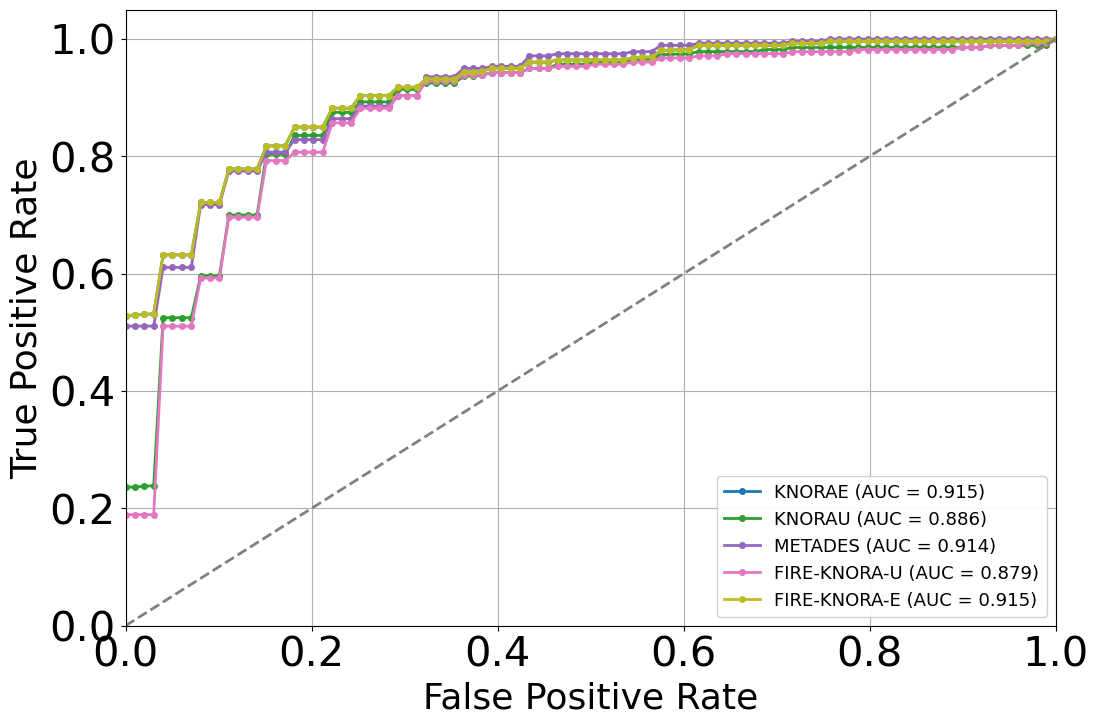

In [78]:
print('\nAverage Metrics over 10 Random States:')
for des_name, metrics in metric_sums_des.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores[des_name])
    std_precision = np.std(precision_scores[des_name])
    std_recall = np.std(recall_scores[des_name])
    std_f1 = np.std(f1_scores[des_name])
    avg_auc = np.mean(roc_aucs[des_name])
    print(f'{des_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')

plot_combined_roc_curve(roc_curves, list(roc_curves.keys()))

Friedman Test Statistic: 3.452054794520523, p-value: 0.48520586524371334
Critical Difference: 1.9288274929443536


<Figure size 1400x1000 with 0 Axes>

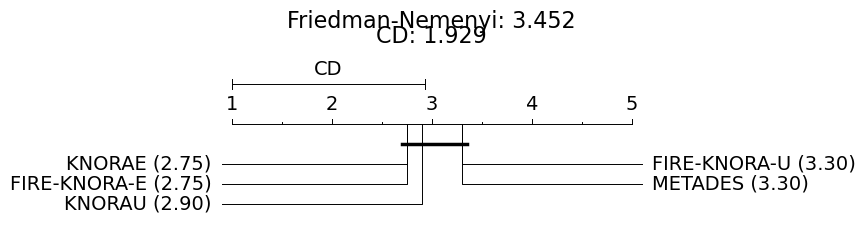

In [79]:
# Filter out empty or invalid results before creating DataFrame
valid_accuracy_scores = {}
for clf_name, scores_list in accuracy_scores.items():
    if scores_list and len(scores_list) > 0:  # Check if list is not empty
        # Filter out NaN and 0 values
        valid_scores = [score for score in scores_list if score != 0 and not np.isnan(score)]
        if len(valid_scores) > 0:  # Only include if we have valid scores
            valid_accuracy_scores[clf_name] = valid_scores

# Check if we have any valid results
if not valid_accuracy_scores:
    print("No valid accuracy scores found for any classifier")
else:
    # Find the minimum length among all valid results
    min_length = min(len(scores) for scores in valid_accuracy_scores.values())
    
    # Truncate all lists to the minimum length
    truncated_scores = {}
    for clf_name, scores_list in valid_accuracy_scores.items():
        truncated_scores[clf_name] = scores_list[:min_length]
    
    # Create DataFrame with truncated scores
    df = pd.DataFrame(truncated_scores)
    
    if df.empty:
        print("No valid data available for statistical analysis")
    else:
        scores = [df[col].values for col in df.columns]
        
        # Perform Friedman test only if we have more than one classifier
        if len(scores) > 1:
            stat, p = friedmanchisquare(*scores)
            print(f'Friedman Test Statistic: {stat}, p-value: {p}')
            
            ranks = df.rank(axis=1, method='average', ascending=False)
            average_ranks = ranks.mean().values
            
            n_datasets = df.shape[0]
            alpha = 0.05
            
            cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
            print(f'Critical Difference: {cd}')
            
            classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
            
            plt.figure(figsize=(14, 10))
            
            graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
            plt.xlabel('Classifiers')
            
            plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)
            plt.text(0.5, 1.10, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)
            
            plt.tight_layout()
        else:
            print("Need at least 2 classifiers for statistical comparison")

Accuracy Comparison Table (DES vs Static Methods)
Rank Method               Accuracy   ±Std     AUC     
------------------------------------------------------------
1    DES_KNORAE           0.8339    ±0.0253 0.9156
2    DES_FIRE-KNORA-E     0.8339    ±0.0253 0.9156
3    DES_KNORAU           0.8304    ±0.0280 0.8866
4    DES_FIRE-KNORA-U     0.8250    ±0.0274 0.8795
5    DES_METADES          0.8250    ±0.0274 0.9145
6    Static_CatBoost      0.8089    ±0.0524 0.8876
7    Static_StackingClassifier 0.7982    ±0.0438 0.9003
8    Static_VotingClassifier 0.7946    ±0.0385 0.8943
9    Static_RandomForest  0.7821    ±0.0569 0.8876
10   Static_GradientBoosting 0.7786    ±0.0480 0.8554
11   Static_AdaBoost      0.7786    ±0.0350 0.8751
12   Static_XGBoost       0.7696    ±0.0489 0.8688
13   DES_DESP             0.0000    ±nan nan
14   DES_DESKNN           0.0000    ±nan nan
15   DES_FIRE-METADES     0.0000    ±nan nan
16   DES_DESMI            0.0000    ±nan nan
17   DES_FIRE-DESP        0.000

<Figure size 1400x600 with 0 Axes>

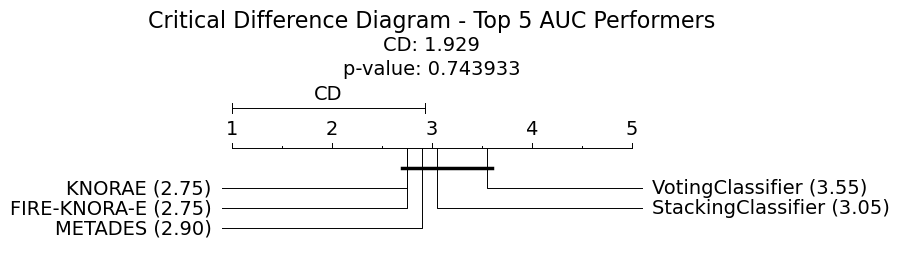

In [80]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import matplotlib.pyplot as plt

# Create comparison tables between DES and Static methods

# Extract accuracy metrics for DES
des_accuracy_data = []
for method_name, metrics in metric_sums_des.items():
    avg_accuracy = metrics['accuracy'] / 10
    std_accuracy = np.std(accuracy_scores[method_name])
    avg_auc = np.mean(roc_aucs[method_name])
    des_accuracy_data.append({
        'Method': f'DES_{method_name}',
        'Accuracy': avg_accuracy,
        'Accuracy_Std': std_accuracy,
        'AUC': avg_auc
    })

# Extract accuracy metrics for Static methods
static_accuracy_data = []
for method_name, metrics in metric_sums_static.items():
    avg_accuracy = metrics['accuracy'] / 10
    std_accuracy = np.std(accuracy_scores_static[method_name])
    avg_auc = np.mean(roc_aucs_static[method_name])
    static_accuracy_data.append({
        'Method': f'Static_{method_name}',
        'Accuracy': avg_accuracy,
        'Accuracy_Std': std_accuracy,
        'AUC': avg_auc
    })

# Combine all data
all_accuracy_data = des_accuracy_data + static_accuracy_data

# Create accuracy comparison table (sorted by accuracy)
accuracy_df = pd.DataFrame(all_accuracy_data)
accuracy_df_sorted = accuracy_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
accuracy_df_sorted['Rank'] = range(1, len(accuracy_df_sorted) + 1)

print("Accuracy Comparison Table (DES vs Static Methods)")
print("=" * 60)
print(f"{'Rank':<4} {'Method':<20} {'Accuracy':<10} {'±Std':<8} {'AUC':<8}")
print("-" * 60)
for _, row in accuracy_df_sorted.iterrows():
    print(f"{row['Rank']:<4} {row['Method']:<20} {row['Accuracy']:.4f}    ±{row['Accuracy_Std']:.4f} {row['AUC']:.4f}")

print("\n")

# Create AUC comparison table (sorted by AUC)
auc_df_sorted = accuracy_df.sort_values('AUC', ascending=False).reset_index(drop=True)
auc_df_sorted['Rank'] = range(1, len(auc_df_sorted) + 1)

print("AUC Comparison Table (DES vs Static Methods)")
print("=" * 60)
print(f"{'Rank':<4} {'Method':<20} {'AUC':<8} {'Accuracy':<10} {'±Std':<8}")
print("-" * 60)
for _, row in auc_df_sorted.iterrows():
    print(f"{row['Rank']:<4} {row['Method']:<20} {row['AUC']:.4f}   {row['Accuracy']:.4f}    ±{row['Accuracy_Std']:.4f}")

# Statistical comparison of top 5 AUC performers
print("\n" + "="*80)
print("STATISTICAL COMPARISON OF TOP 5 AUC PERFORMERS")
print("="*80)

# Get top 5 methods by AUC
top_5_auc = auc_df_sorted.head(5)
print("Top 5 methods by AUC:")
for _, row in top_5_auc.iterrows():
    print(f"{row['Rank']}. {row['Method']}: {row['AUC']:.4f}")

# Extract AUC scores for top 5 methods
top_5_methods = top_5_auc['Method'].tolist()
top_5_auc_scores = []

for method in top_5_methods:
    if method.startswith('DES_'):
        method_key = method.replace('DES_', '')
        scores = roc_aucs[method_key]
    elif method.startswith('Static_'):
        method_key = method.replace('Static_', '')
        scores = roc_aucs_static[method_key]
    else:  # Classical methods
        method_key = method.replace('Classical_', '')
        scores = roc_aucs_classic[method_key]
    
    top_5_auc_scores.append(scores)

# Perform Friedman test on AUC scores
print(f"\nFriedman Test on AUC scores for top 5 methods:")
auc_stat, auc_p = friedmanchisquare(*top_5_auc_scores)
print(f'Friedman Test Statistic: {auc_stat:.4f}')
print(f'p-value: {auc_p:.6f}')

if auc_p < 0.05:
    print("Result: Significant differences detected between methods (p < 0.05)")
else:
    print("Result: No significant differences detected between methods (p >= 0.05)")

# Create dataframe for ranking analysis
top_5_auc_df = pd.DataFrame({method: scores for method, scores in zip(top_5_methods, top_5_auc_scores)})

# Calculate ranks and critical difference
auc_ranks = top_5_auc_df.rank(axis=1, method='average', ascending=False)
auc_average_ranks = auc_ranks.mean().values
n_datasets_top5 = top_5_auc_df.shape[0]

auc_cd = compute_CD(auc_average_ranks, n_datasets_top5, alpha='0.05')
print(f'Critical Difference: {auc_cd:.4f}')

# Create CD diagram
top_5_classifiers_ranked = [f"{method.split('_', 1)[1]} ({rank:.2f})" for method, rank in zip(top_5_methods, auc_average_ranks)]

plt.figure(figsize=(14, 6))
graph_ranks(auc_average_ranks, top_5_classifiers_ranked, cd=auc_cd, width=6, textspace=1)
plt.text(0.5, 1.20, f'CD: {auc_cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.05, "p-value: {:.6f}".format(auc_p), horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.title('Critical Difference Diagram - Top 5 AUC Performers', fontsize=16, pad=40)
plt.tight_layout()
plt.show()